# Image Encoding on Simulated Noisy Hardware

In [1]:
from math import log
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '.')

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library import MCXGate
from qiskit.providers.fake_provider import FakeHanoi
import mapomatic as mm

After importing all of the required modules, we need to extract information from our noisy backend simulator. In this case I am using FakeHanoi however you can feel free to choose others found [here](https://qiskit.org/documentation/apidoc/providers_fake_provider.html#:~:text=The%20fake%20backends%20are%20built,%2C%20error%20rate%2C%20etc.). As for our optimizations in this, we are only using the qiskit transpiler and mapomatic. We have a measurement readout error mitigation called [mthree](https://qiskit.org/documentation/partners/mthree/) where more information can be found [here](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html). We cannot use mthree for these optimization metrics because it actually involves the measurement of the circuits themselves which we are not doing here. I will be implementing the mthree module in a later notebook.

In [2]:
qbackend = FakeHanoi()

properties = qbackend.properties()
config = qbackend.configuration()
defaults = qbackend.defaults()

basis_gates = config.basis_gates

#***** Display Gate Errors *****
# Compute average SX gate error for backend
avg_sx_err = np.mean([properties.gate_error("sx", i) for i in range(27)])

# Compute average X gate error for backend
avg_x_err = np.mean([properties.gate_error("x", i) for i in range(27)])

# Compute average RZ gate error for backend
avg_rz_err = np.mean([properties.gate_error("rz", i) for i in range(27)])

avg_single_qb_err = (avg_sx_err + avg_x_err + avg_rz_err)/3


# Compute the average CNOT gate error for backend
avg_cx_err = np.mean(
    [properties.gate_error("cx", (cm[0], cm[1])) for cm in config.coupling_map]
)

print("Basis Gates:", basis_gates)

# Display gate error averages
print(f"Average CX gate error: {avg_cx_err:.5f}")
print(f"Average single qubit SX gate error: {avg_sx_err:.5f}")
print(f"Average single qubit RZ gate error: {avg_rz_err:.5f}")
print(f"Average single qubit X gate error: {avg_x_err:.5f}")

Basis Gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
Average CX gate error: 0.00934
Average single qubit SX gate error: 0.00022
Average single qubit RZ gate error: 0.00000
Average single qubit X gate error: 0.00022


What we have done is extract the basis gates and their respective error rate for the hardware. These are the gates which are executed on the real device. Whichever unitaries are used in your circuit design, they are decomposed into series of these gates. We average the error accross the hardware for each gate for future computational time.

Next, we will import some methods to be used. First is the gate fidelity calculation called compute_circuit_gate_fidelity. It is a relatively simple heuristic which is presented by IBM:


$f_{circuit} = \bar{f}^{N_{1Q}}_{1Q}\bar{f}^{N_{2Q}}_{2Q}$


where $\bar{f}_{1Q}$ and $\bar{f}_{2Q}$ are the average single and two gate error rates for the hardware with $N_{1Q}$ and $N_{2Q}$ being the number of single and two qubit gates in the circuit.

The next method is split_img which slices our image in the form of a numpy array into the desired domains. What it is really doing is reformatting our 2D image into a new 2D image with a different width.

The third method is find_qregs. This is used to determine the initial mapping of the circuit design to hardware topology. The purpose of this is to minimize the number of cx operations in the circuit. More information about this method can be found [here](https://github.com/Qiskit-Partners/mapomatic). Note that it is possible to use any error function you can logically contrive. However, since our main focus on QHED was the cx error (which also has an error rate an order of magnitude larger than single qubit gates) I choose to save computational time by only focusing on the cx count.

The fourth method is image_prep which receives the path to a .png or .jpeg image and reshapes it to a numpy array of your desired size. For the purpose of this particle data, I will not be using this function since I converted that image into a txt file already, but I thought to include this method in case you want to experiment with other images.

The last method actually builds the image encoding circuit. The desired vector (or image sub domain) is normalized such that for all vector elements $[c_{0}, c_{1}...c_{n-1}]$:

$\sum|c_{i}|^{2} = 1$

From here, the normalized vector is sent to the qiskit StatePreparation method which creates the image encoding circuit. We then compose that to our empty circuit and return the object.

In [3]:
def compute_circuit_gate_fidelity(
    num_two_q_gates, num_single_q_gates, ave_two_q_gate_fid, ave_single_q_fid
):
    """
    Estimate the fidelity of the combined two-qubit and single-qubit gates in a circuit.

    Args:
        num_two_q_gates - int; the number of two-qubit gates. Assumes the same two-qubit gate is used throughout the circuit.
        num_single_q_gates - int; the number of single-qubit gates. Assumes the same single-qubit gate is used throughout the circuit
        ave_two_q_gate_fid - float; the average fidelity of the two-qubit gate
        ave_single_q_fit - float; the average fidelity of the single-qubit gate

    Returns:
        fidelity - float; estimated fidelity of circuit operations (see paper for details)
    """

    return (ave_two_q_gate_fid**num_two_q_gates) * (
        ave_single_q_fid**num_single_q_gates
    )



def split_img(img, wanted_parts=1):
    '''
    Split a 1D array into a series of evenly divided arrays, returning a 2D array
    
    Args:
        img - 1D numpy array
        wanted_parts - the desired number of sub divisions
        
    Returns:
        2D numpy array comprised of the sub divisions
    '''
    length = len(img)
    return np.array([ img[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ])

def find_qregs(qc):
    '''
    Use mapomatic functionality to find an optimal circuit layout for some n number of qubits.
    Because qiskit is stochastic, we transpile some n qubit circuit 20 times and choose the mapping
    with the lowest cx count for that backend.
    
    Args:
        qc - some n qubit quantum circuit (in this case we use an amplitude encoded sub domain)
        
    Returns:
        qregs - a list of quantum registers for the initial layout of an n qubit circuit to be used
                by the transpiler
    '''
    #Ancillary circuit, Mapped
    trans_qc_list = transpile([qc]*20, backend=qbackend, optimization_level=3)
    best_cx_count = [circ.count_ops()['cx'] for circ in trans_qc_list]
    best_idx = np.argmin(best_cx_count)
    best_qc = trans_qc_list[best_idx]
    best_small_qc = mm.deflate_circuit(best_qc)
    layouts = mm.matching_layouts(best_small_qc, qbackend)
    scores = mm.evaluate_layouts(best_small_qc, layouts, qbackend)
    return scores[0][0]



def image_prep(image_path, desired_image_size):
    '''
    Prepare an image in the form of a 2D numpy array with [0-256) pixel values.
    
    Args:
        image_path - relative path to the image
        desired_image_size - reshapes the image to be nxn. This is useful for when 
                             we want even sub divisions of an image.
                             
    Returns:
        2D numpy array of the image.
    '''
    img = Image.open(image_path)
    img = ImageOps.grayscale(img)
    img = img.resize((desired_image_size,desired_image_size))
    # convert image to numpy array
    return np.asarray(img)



def build_circ(image):
        '''
        Builds the Image encoding circuit.
        
        Args:
            image - the 1D vector to be encoded
            
        Returns:
            qc - the image encoded quantum circuit object
        '''
        vect_norm = image.flatten()/np.linalg.norm(image)
        n_qubits = int(log(vect_norm.size, 2))

        qr = QuantumRegister(n_qubits, name="q")
        cr = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(qr, cr)
        
        #State Prep
        f = StatePreparation(vect_norm)
        qc.compose(f, qubits = list(range(0,n_qubits)), inplace=True)
        
        #Measure
        for i in range(0, n_qubits):
            qc.measure(i,i)

        return qc

We're ready to get into it now. We can load whichever data we want so long as they end up in the form of a numpy array, I have left a few examples commented out. Below is the particle data. The text image is loaded into a 2D numpy array, flattened (to 1D), then padded with 64 trailing 0's. The original image is 112x63 = 4,032 pixels. To achieve even divisions of $2^{n}$ then the total image size must also be of size $2^{n}$. The end result is a 1D representation of the particle image with trailing 0's.

I am also defining some lists to store the calculated values for the fidelity, cx count, and depth as well as the qubit domains we which to test. We also create a dictionary for error exception handling. In python 3.9, we can merge dictionaries using:  

new_dictionary = baseline_dict | produced_dict

So if we return circuits which do not have certain basis gates we can overwrite them with a value of 0. Say, our circuit produced has no rz or cx gates but contains x and sx. Qiskit will produce the dictionary {'sx': 13, 'x': 5} and without the cx or rz contributions we will receive a key error and our fidelity calculation will crash:

new_dict = {'id': 0, 'rz': 0, 'sx': 0, 'x': 0, 'cx': 0, 'reset': 0} | {'sx': 13, 'x': 5}

new_dict = {'id': 0, 'rz': 0, 'sx': 13, 'x': 5, 'cx': 0, 'reset': 0}

Qiskit does not do these things for us so to avoid error we must implement it ourselves.

In [4]:
# We can use this to load Med Data
# n = 128 reshapes the image to 128x128
# img_med[img_med < 50] = 0 this line sets any pixel values under 50 to be equal to 0
'''
n = 128
img_med = np.copy(image_prep("./img/NaF-PROSTATE-01-0001_22.png", n))
img_med[img_med < 50] = 0
'''
# We can use this to import a sample of MNIST data
# Requires the modules to be imported
'''
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
img_mnist = np.copy(train_X[0])
img_mnist = np.pad(img_mnist.flatten(),(0,240), 'constant')
'''


img_par = np.loadtxt("./img/case-0_1.txt")
img_par = np.pad(img_par.flatten(),(0,64), 'constant')

#Swap between images with this
img = img_par


# Feel free to adjust this range to your liking
qubits = list(range(2,8))

avg_cx = []
avg_cx_op = []

avg_fid = []
avg_fid_op = []

avg_depth = []
avg_depth_op = []

# This dictionary is created for error exception handling
basis_dict = {gate:0 for gate in basis_gates}

We work now in loops of qubit domain decompositions. First, the image domain is split based on the number of qubits we have. We receive image vectors of size $2^{n}$. We then calculate the most optimal quantum register topology using mapomatic. From there, we transpile our circuits. One set is fully optimized, the other set is not. We can then calculate the metrics for each set of circuits and take the average. See the comments in the code for more details.

In [5]:
for n_qubits in qubits:
    qc_trans = []
    qc_trans_op = []

    print("***** Working on", n_qubits, "of", qubits[-1],"qubits Decomp *****")

    '''
    First we split the image into desired domains. image_decomp is now a 2D array with
    each vector being of size 2^n_qubits
    '''
    n = 2**(n_qubits)
    image_decomp = split_img(img.flatten(), wanted_parts = int(img.size/n))


    '''
    This finds some non zero domain, builds a circuit, and finds the mapping with the
    least number of cx gates. It is sometimes possible that no cx gates exist in the circuit
    so we use some default [0,1,2...n_qubits-1] list.
    '''
    test = [np.sum(x) for x in image_decomp]
    map_idx = np.argmax(test)
    try:
        q_regs = find_qregs(build_circ(image_decomp[map_idx]))
    except:
        print("No cx gates, using default mapping...")
        q_regs = list(range(0,n_qubits))


    '''
    Now we build and transpile the circuits for each sub domain.
    First, we can only check for the non-zero sub domains since we cannot encode
    a [0,0,0...0] vector into a circuit (it cannot be normalized to 1). One circuit is
    transpiled with the efficient backend mapping as well as a level 3 optimization level.
    The other circuit has an optimization level of 0 without the register mapping. The idea
    is to see how much the optimizations make a difference with expanding domain sizes.
    
    Due to the stochastic nature of qiskit (as well as the endless mem-copy operations),
    sometimes a certain domain fails to transpile and must be revisited.
    '''
    for sub_img in image_decomp:
        if np.sum(sub_img) > 0:
            qc = build_circ(sub_img)

            qc_trans_op.append(
            transpile(qc, 
                basis_gates=basis_gates, 
                backend=qbackend, 
                initial_layout=q_regs, 
                optimization_level=3)
            )


            qc_trans.append(
            transpile(qc, 
                basis_gates=basis_gates, 
                backend=qbackend, 
                optimization_level=0)
            )




            

    '''
    Now we begin taking metrics. To find the depth of the circuit, I have experimented to find that
    6 layers of decomposition for the statevector method is appropriate to receive the lowest level
    of basis gates. 
    '''
    depth_sum_op = 0
    depth_sum = 0
    
    fid_sum_op = 0
    fid_sum = 0
    
    cx_sum_op = 0
    cx_sum = 0
    
    '''
    ***** Metrics for optimized Circuits *****
    '''
    for circ in qc_trans_op:
        # Depth
        depth_sum_op += circ.decompose().decompose().decompose().decompose().decompose().decompose().decompose().depth()


        # Count ops. Calculate fidelity, store fidelity, store cx count
        qc_d_ops = circ.count_ops()
        qc_d_ops = basis_dict | qc_d_ops


        fid_d = compute_circuit_gate_fidelity(qc_d_ops["cx"], qc_d_ops["sx"], 1 - avg_cx_err, 1 - avg_single_qb_err)


        fid_sum_op += fid_d
        cx_sum_op += qc_d_ops['cx']
        
       
    '''
    ***** Metrics for baseline, unoptimized Circuits *****
    '''
    for circ in qc_trans:
        depth_sum += circ.decompose().decompose().decompose().decompose().decompose().decompose().decompose().depth()

        
        # Count ops. Calculate fidelity, store fidelity, store cx count
        qc_d_ops = circ.count_ops()
        qc_d_ops = basis_dict | qc_d_ops

        fid_d = compute_circuit_gate_fidelity(qc_d_ops["cx"], qc_d_ops["sx"], 1 - avg_cx_err, 1 - avg_single_qb_err)

        fid_sum += fid_d
        cx_sum += qc_d_ops['cx']
        
        
    print("avg_depth_op =", depth_sum_op/len(qc_trans_op))
    print("avg_depth =", depth_sum/len(qc_trans))
    print('\n\n')
    avg_depth.append(depth_sum/len(qc_trans))
    avg_depth_op.append(depth_sum_op/len(qc_trans_op))

    print("avg_fid_op =", fid_sum_op/len(qc_trans_op))
    print("avg_fid =", fid_sum/len(qc_trans))
    print('\n\n')
    avg_fid.append(fid_sum/len(qc_trans))
    avg_fid_op.append(fid_sum_op/len(qc_trans_op))

    print("avg_cx_op =", cx_sum_op/len(qc_trans_op))
    print("avg_cx =", cx_sum/len(qc_trans))
    print('\n\n')
    avg_cx.append(cx_sum/len(qc_trans))
    avg_cx_op.append(cx_sum_op/len(qc_trans_op))
        


        
    

***** Working on 2 of 7 qubits Decomp *****
avg_depth_op = 10.529411764705882
avg_depth = 13.970588235294118



avg_fid_op = 0.9947529946523721
avg_fid = 0.98969812472981



avg_cx_op = 0.5294117647058824
avg_cx = 1.0588235294117647



***** Working on 3 of 7 qubits Decomp *****
avg_depth_op = 29.441176470588236
avg_depth = 33.529411764705884



avg_fid_op = 0.9543412508987825
avg_fid = 0.9485116978101308



avg_cx_op = 4.9411764705882355
avg_cx = 5.617647058823529



***** Working on 4 of 7 qubits Decomp *****
avg_depth_op = 70.1470588235294
avg_depth = 76.20588235294117



avg_fid_op = 0.9062731095233305
avg_fid = 0.8377939974111045



avg_cx_op = 10.382352941176471
avg_cx = 19.441176470588236



***** Working on 5 of 7 qubits Decomp *****
avg_depth_op = 152.55882352941177
avg_depth = 166.26470588235293



avg_fid_op = 0.7463314386921905
avg_fid = 0.6868676461583366



avg_cx_op = 32.26470588235294
avg_cx = 42.14705882352941



***** Working on 6 of 7 qubits Decomp *****
avg_depth_op

In [6]:
# You can use this to copy and paste the raw data wherever you wish

print("avg_cx_op = {}\n".format(avg_cx_op))
print("avg_cx = {}\n".format(avg_cx))

print("avg_fid_op = {}\n".format(avg_fid_op))
print("avg_fid = {}\n".format(avg_fid))

print("avg_depth_op = {}\n".format(avg_depth_op))
print("avg_depth = {}\n".format(avg_depth))


avg_cx_op = [0.5294117647058824, 4.9411764705882355, 10.382352941176471, 32.26470588235294, 81.5, 180.8709677419355]

avg_cx = [1.0588235294117647, 5.617647058823529, 19.441176470588236, 42.14705882352941, 103.94117647058823, 255.32258064516128]

avg_fid_op = [0.9947529946523721, 0.9543412508987825, 0.9062731095233305, 0.7463314386921905, 0.49700262084763336, 0.23879005424458302]

avg_fid = [0.98969812472981, 0.9485116978101308, 0.8377939974111045, 0.6868676461583366, 0.4220610383366418, 0.15102210282885917]

avg_depth_op = [10.529411764705882, 29.441176470588236, 70.1470588235294, 152.55882352941177, 316.8529411764706, 686.8709677419355]

avg_depth = [13.970588235294118, 33.529411764705884, 76.20588235294117, 166.26470588235293, 354.5, 791.5806451612904]



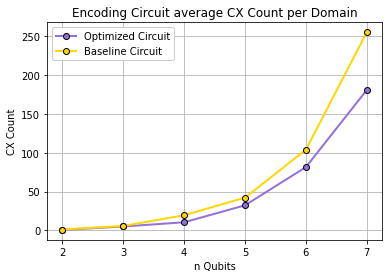

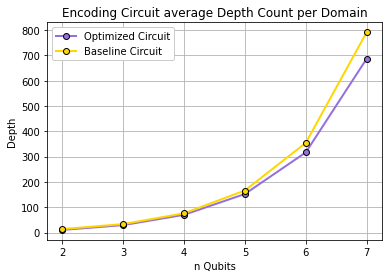

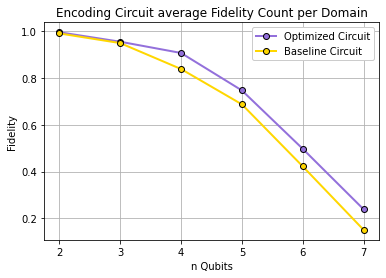

In [7]:
fig, ax = plt.subplots()
plt.plot(
    qubits,
    avg_cx_op,
    "-o",
    label="Optimized Circuit",
    linewidth=2,
    color="mediumpurple",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    avg_cx,
    "-o",
    label="Baseline Circuit",
    linewidth=2,
    color="gold",
    markeredgecolor="k"
)

plt.ylabel("CX Count")
plt.xlabel("n Qubits")
plt.xticks(qubits)
plt.legend(framealpha=1)
plt.grid()
plt.title("Encoding Circuit average CX Count per Domain")
#plt.savefig("enc_cx.png")
plt.show()



fig, ax = plt.subplots()
plt.plot(
    qubits,
    avg_depth_op,
    "-o",
    label="Optimized Circuit",
    linewidth=2,
    color="mediumpurple",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    avg_depth,
    "-o",
    label="Baseline Circuit",
    linewidth=2,
    color="gold",
    markeredgecolor="k"
)
plt.ylabel("Depth")
plt.xlabel("n Qubits")
plt.xticks(qubits)
plt.legend(framealpha=1)
plt.grid()
plt.title("Encoding Circuit average Depth Count per Domain")
#plt.savefig("enc_depth.png")
plt.show()




fig, ax = plt.subplots()
plt.plot(
    qubits,
    avg_fid_op,
    "-o",
    label="Optimized Circuit",
    linewidth=2,
    color="mediumpurple",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    avg_fid,
    "-o",
    label="Baseline Circuit",
    linewidth=2,
    color="gold",
    markeredgecolor="k"
)
plt.ylabel("Fidelity")
plt.xlabel("n Qubits")
plt.xticks(qubits)
plt.legend(framealpha=1)
plt.grid()
plt.title("Encoding Circuit average Fidelity Count per Domain")
#plt.savefig("enc_fid.png")
plt.show()


To make things explicit, I had originally used the plots I presented in the proposal to explain how amplitude encoding fidelity issues are best mitigated by domain decomposition. No matter our fancy optimizations, we still expect to receive an exponential growth in circuit depth with regards to the number of encoding qubits, because that is how amplitude encoding is engineered. Do the optimizations help? Of course they do. However, the encoding of data is a different area of research entirely which is not my own area of focus. My area of focus led me to reengineer the QHED circuit which had far more improvement over the circuit fidelity than these optimizations alone (although they still help a great deal!). These optimizations are almost a "bandaid" which we can apply to most if not all circuits through Qiskit. They are helpful, but to produce notable results we need to do more than apply a bandaid.